# DTSA 5510 FINAL PROJECT
GitHub link: https://github.com/jhoglund1/DTSA-5510

In [866]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, BisectingKMeans, DBSCAN, KMeans
from sklearn.metrics import adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, silhouette_score     

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## DATA INGESTION

For this project, the data used is from the UCI Machine Learning Repository (source below). The data was collected from various hospitals, clinics, and maternal heath care centers in rural areas in Bangladesh. It provides information in order to measure risk for maternal mortality from 6 numerical features: Age, Systolic Blood Pressure (SystolicBP), Diastolic Blood Pressure (DiastolicBP), Blood Sugar (BS), Body Temperature (BodyTemp), and Heart Rate (HeartRate). The categorical target feature is labeled as RiskLevel and has three categories: Low Risk, Medium Risk, and High Risk. There 1014 total instances.

Source:
Ahmed, M. (2020). Maternal health risk. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/863/maternal+health+risk 

In [605]:
# Read in dataset
data = pd.read_csv('/Users/jcorm/Documents/Maternal Health Risk Data Set.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


## DATA CLEANING

##### Check for null values in dataset
No null values exist in this dataset so no rows need to be dropped.

In [607]:
data.isnull().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

##### Refactor target feature
Refactor RiskLevel feature from strings to ints for use in calculating scores for models. Mapping is: 0 - Low Risk, 1 - Med Risk, 2 - High Risk

In [609]:
data['RiskLevel'] = data['RiskLevel'].map({'low risk':0, 'mid risk':1, 'high risk':2}).astype(int)

##### Check for categorical data imbalances
For the only categorical feature, we will print the percentage for how many of each category exist in the dataset as well as plot the counts for each risk level for visualization.
Low Risk has the highest amount of instances with 40% of the total amount while High Risk has the lowest amount with ~27% of the instances. 
While the categories are not evenly split, there is still a good amount of the High Risk category (> 15%), so no imbalance adjustments for High Risk need to occur.

RiskLevel
0    0.400394
1    0.331361
2    0.268245
Name: count, dtype: float64


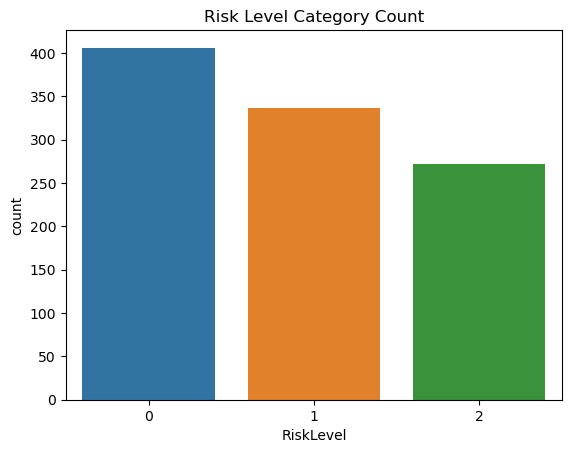

In [611]:
print(data['RiskLevel'].value_counts() / len(data))
sns.countplot(data, x='RiskLevel').set_title('Risk Level Category Count')
plt.show()

##### Check for numerical data imbalances

Plot a box plot with the 6 numerical features. There is a small outlier for Age but it is very close to the upper quartile so it is reasonable to keep it. There are no outliers for DiastolicBP. The outliers for SystolicBP, BS, BodyTemp, and HeartRate are considered below.

<Axes: >

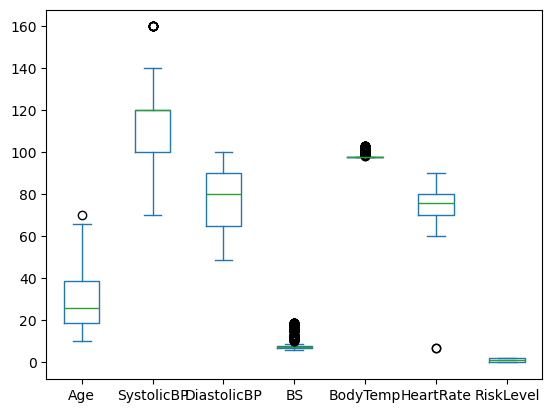

In [613]:
data.plot(kind='box')

###### Check SystolicBP outliers

The boxplot shows an outlier around 160. A further look at SystolicBP's greater than 150 show that there are 10 rows where the SystolicBP is 160. Further research says that 160 is an appropriate possible value for SystolicBP, so these rows can stay.

<Axes: >

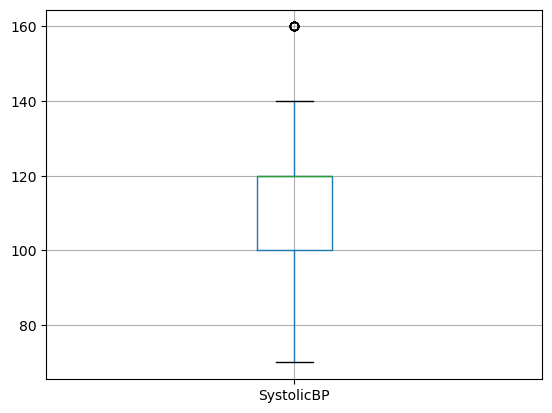

In [615]:
data.boxplot(['SystolicBP'])

In [617]:
data.loc[(data['SystolicBP'] >= 150)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
123,40,160,100,19.0,98.0,77,2
130,40,160,100,19.0,98.0,77,2
166,40,160,100,19.0,98.0,77,2
262,40,160,100,19.0,98.0,77,2
362,40,160,100,19.0,98.0,77,2
538,40,160,100,19.0,98.0,77,2
583,40,160,100,19.0,98.0,77,2
689,40,160,100,19.0,98.0,77,2
961,40,160,100,19.0,98.0,77,2
994,40,160,100,19.0,98.0,77,2


###### Check HeartRate outliers

The boxplot shows an outlier below 10. A further look at HeartRate's less than 40 show that there are 2 instances where the HeartRate is 7. This is an essentially impossible value for a heart rate. Since there are only 2 instances these rows can just be removed from the dataset.

<Axes: >

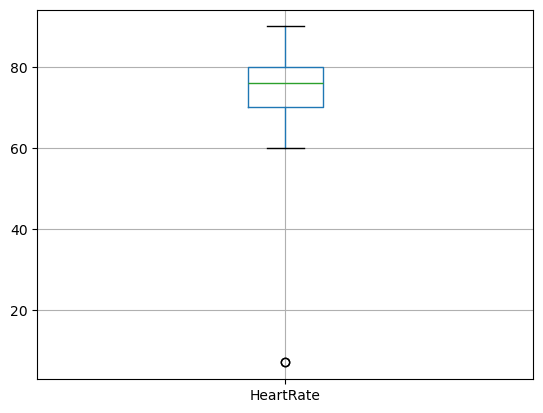

In [619]:
data.boxplot(['HeartRate'])

In [621]:
data.loc[(data['HeartRate'] < 40)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,0
908,16,120,75,7.9,98.0,7,0


In [623]:
data = data.drop(data[data['HeartRate'] == 7].index)

###### Check BS outliers

The boxplot shows several outliers ranging from 10 to ~19. A further look at Blood Sugar values less than 10, show that there are 210 instances of high BS levels. Further research shows that all these outliers can be realistic values for Blood Sugar, so all these outliers can stay in the dataset.

<Axes: >

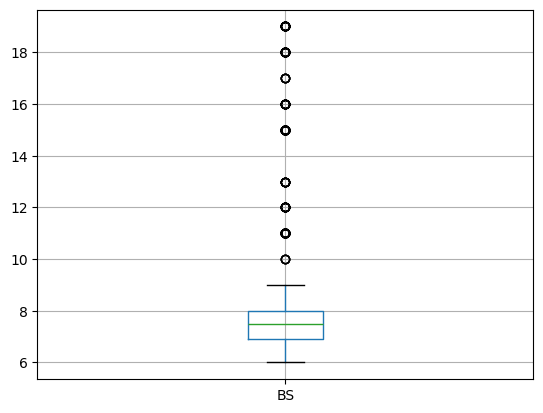

In [625]:
data.boxplot(['BS'])

In [627]:
data.loc[(data['BS'] >= 10)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
7,35,85,60,11.0,102.0,86,2
9,42,130,80,18.0,98.0,70,2
14,48,120,80,11.0,98.0,88,1
...,...,...,...,...,...,...,...
1008,48,120,80,11.0,98.0,88,2
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2


###### Check BodyTemp outliers

The boxplot shows several outliers ranging from >98 to 103. A further look at BodyTemp levels greater than 98, show that there are 210 instances of high Body Temperature levels. All these values are realistic options for Body Temperature, so all these outliers can stay in the dataset.

<Axes: >

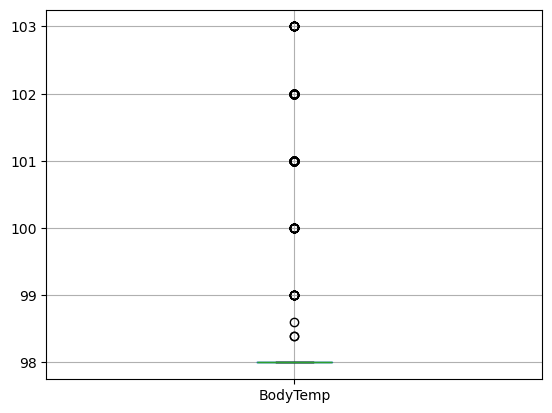

In [629]:
data.boxplot(['BodyTemp'])

In [631]:
data.loc[(data['BodyTemp'] > 98)]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
2,29,90,70,8.00,100.0,80,2
7,35,85,60,11.00,102.0,86,2
13,20,120,75,7.01,100.0,70,1
18,30,120,80,6.90,101.0,76,1
35,12,95,60,6.10,102.0,60,0
...,...,...,...,...,...,...,...
1000,12,90,60,11.00,102.0,60,2
1004,13,90,65,9.00,101.0,80,2
1005,17,90,65,7.70,103.0,67,2
1006,17,85,60,6.30,102.0,86,2


#### Data Cleaning Summary

This dataset was relatively clean. No nan values existed. There were 2 outliers in the BS feature that gave impossible values, so those 2 rows containing the outliers were removed. The outliers were accessed and determined to be realistic values. The target feature was checked for data imbalance and determined to be appropriately balanced. The categories for the target were changed to numerical representations to aid in model evaluation later. Info and descriptions for the cleaned dataset is below.

In [633]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1012 non-null   int64  
 1   SystolicBP   1012 non-null   int64  
 2   DiastolicBP  1012 non-null   int64  
 3   BS           1012 non-null   float64
 4   BodyTemp     1012 non-null   float64
 5   HeartRate    1012 non-null   int64  
 6   RiskLevel    1012 non-null   int64  
dtypes: float64(2), int64(5)
memory usage: 63.2 KB


In [635]:
data.describe()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
count,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000,1012.000000
mean,29.899209,113.184783,76.463439,8.727619,98.666403,74.434783,0.869565
std,13.473560,18.419618,13.899372,3.296583,1.372421,7.521857,0.807227
min,10.000000,70.000000,49.000000,6.000000,98.000000,60.000000,0.000000
25%,19.000000,100.000000,65.000000,6.900000,98.000000,70.000000,0.000000
50%,26.000000,120.000000,80.000000,7.500000,98.000000,76.000000,1.000000
75%,39.000000,120.000000,90.000000,8.000000,98.000000,80.000000,2.000000
max,70.000000,160.000000,100.000000,19.000000,103.000000,90.000000,2.000000


## EXPLORATORY DATA ANALYSIS

##### Histogram
The histogram plotted below shows that Age has a right skewed somewhat normal distribution. The other 4 features have data that is spread out enough so as to not be able to make any assumptions about the distribution of each feature. The HeartRate feature has a large gap of reported heart rates between ~ 72 and 75. It seems unusual that there would be no heart rates reported at the potential peak of the distribution. This appears to possibly be a rounding error in the data collection process. It doesn't seem to be too impactful for the overall models.

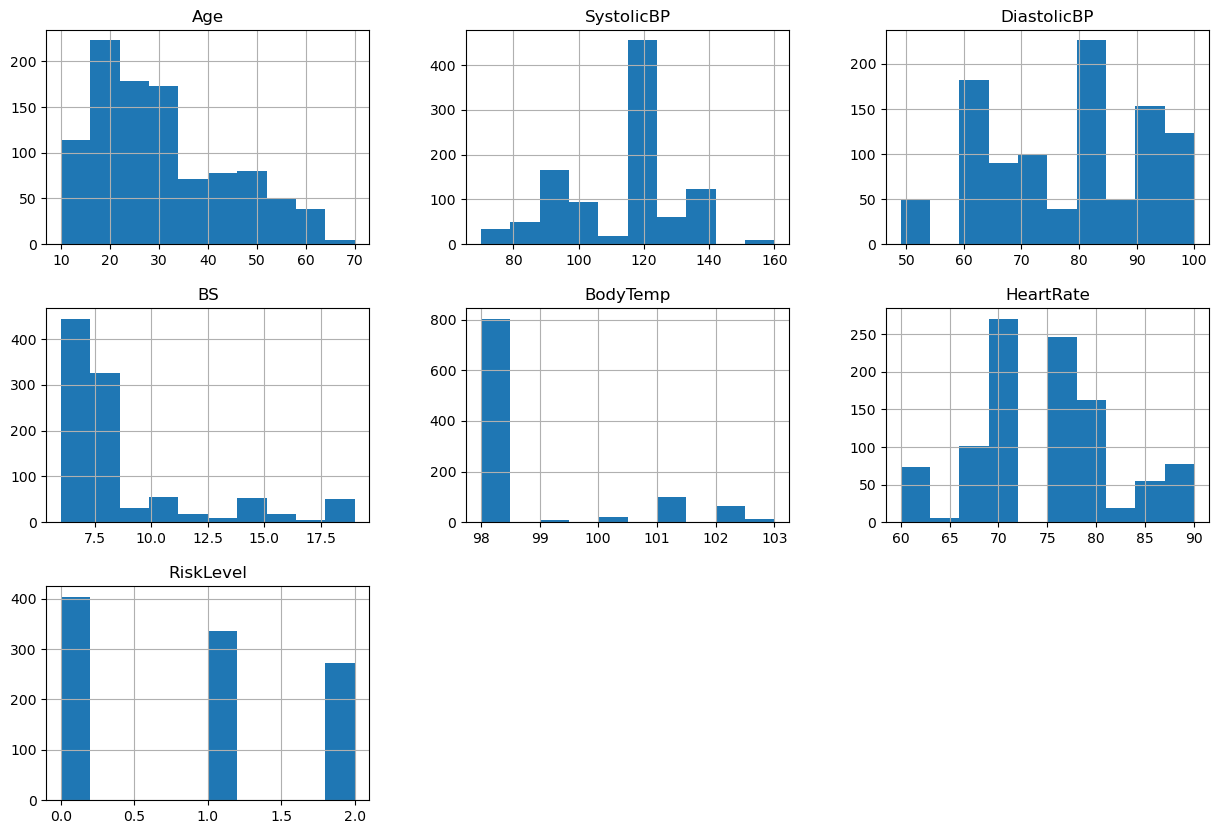

In [637]:
data.hist(figsize=(15, 10))
plt.show()

##### Pairwise Plot

The pairwise plot shows that most of the feature pairs have relatively evenly distributed data points, which shows no collinearity between the features. The pairs relating to BS have some bunching in the lower part of the charts but this makes sense since the majority of the BS values are on the lower end. There may a slight linear relationship between SystolicBP and DiastolicBP, which we will pay attention to in the correlation matrix chart further below. 

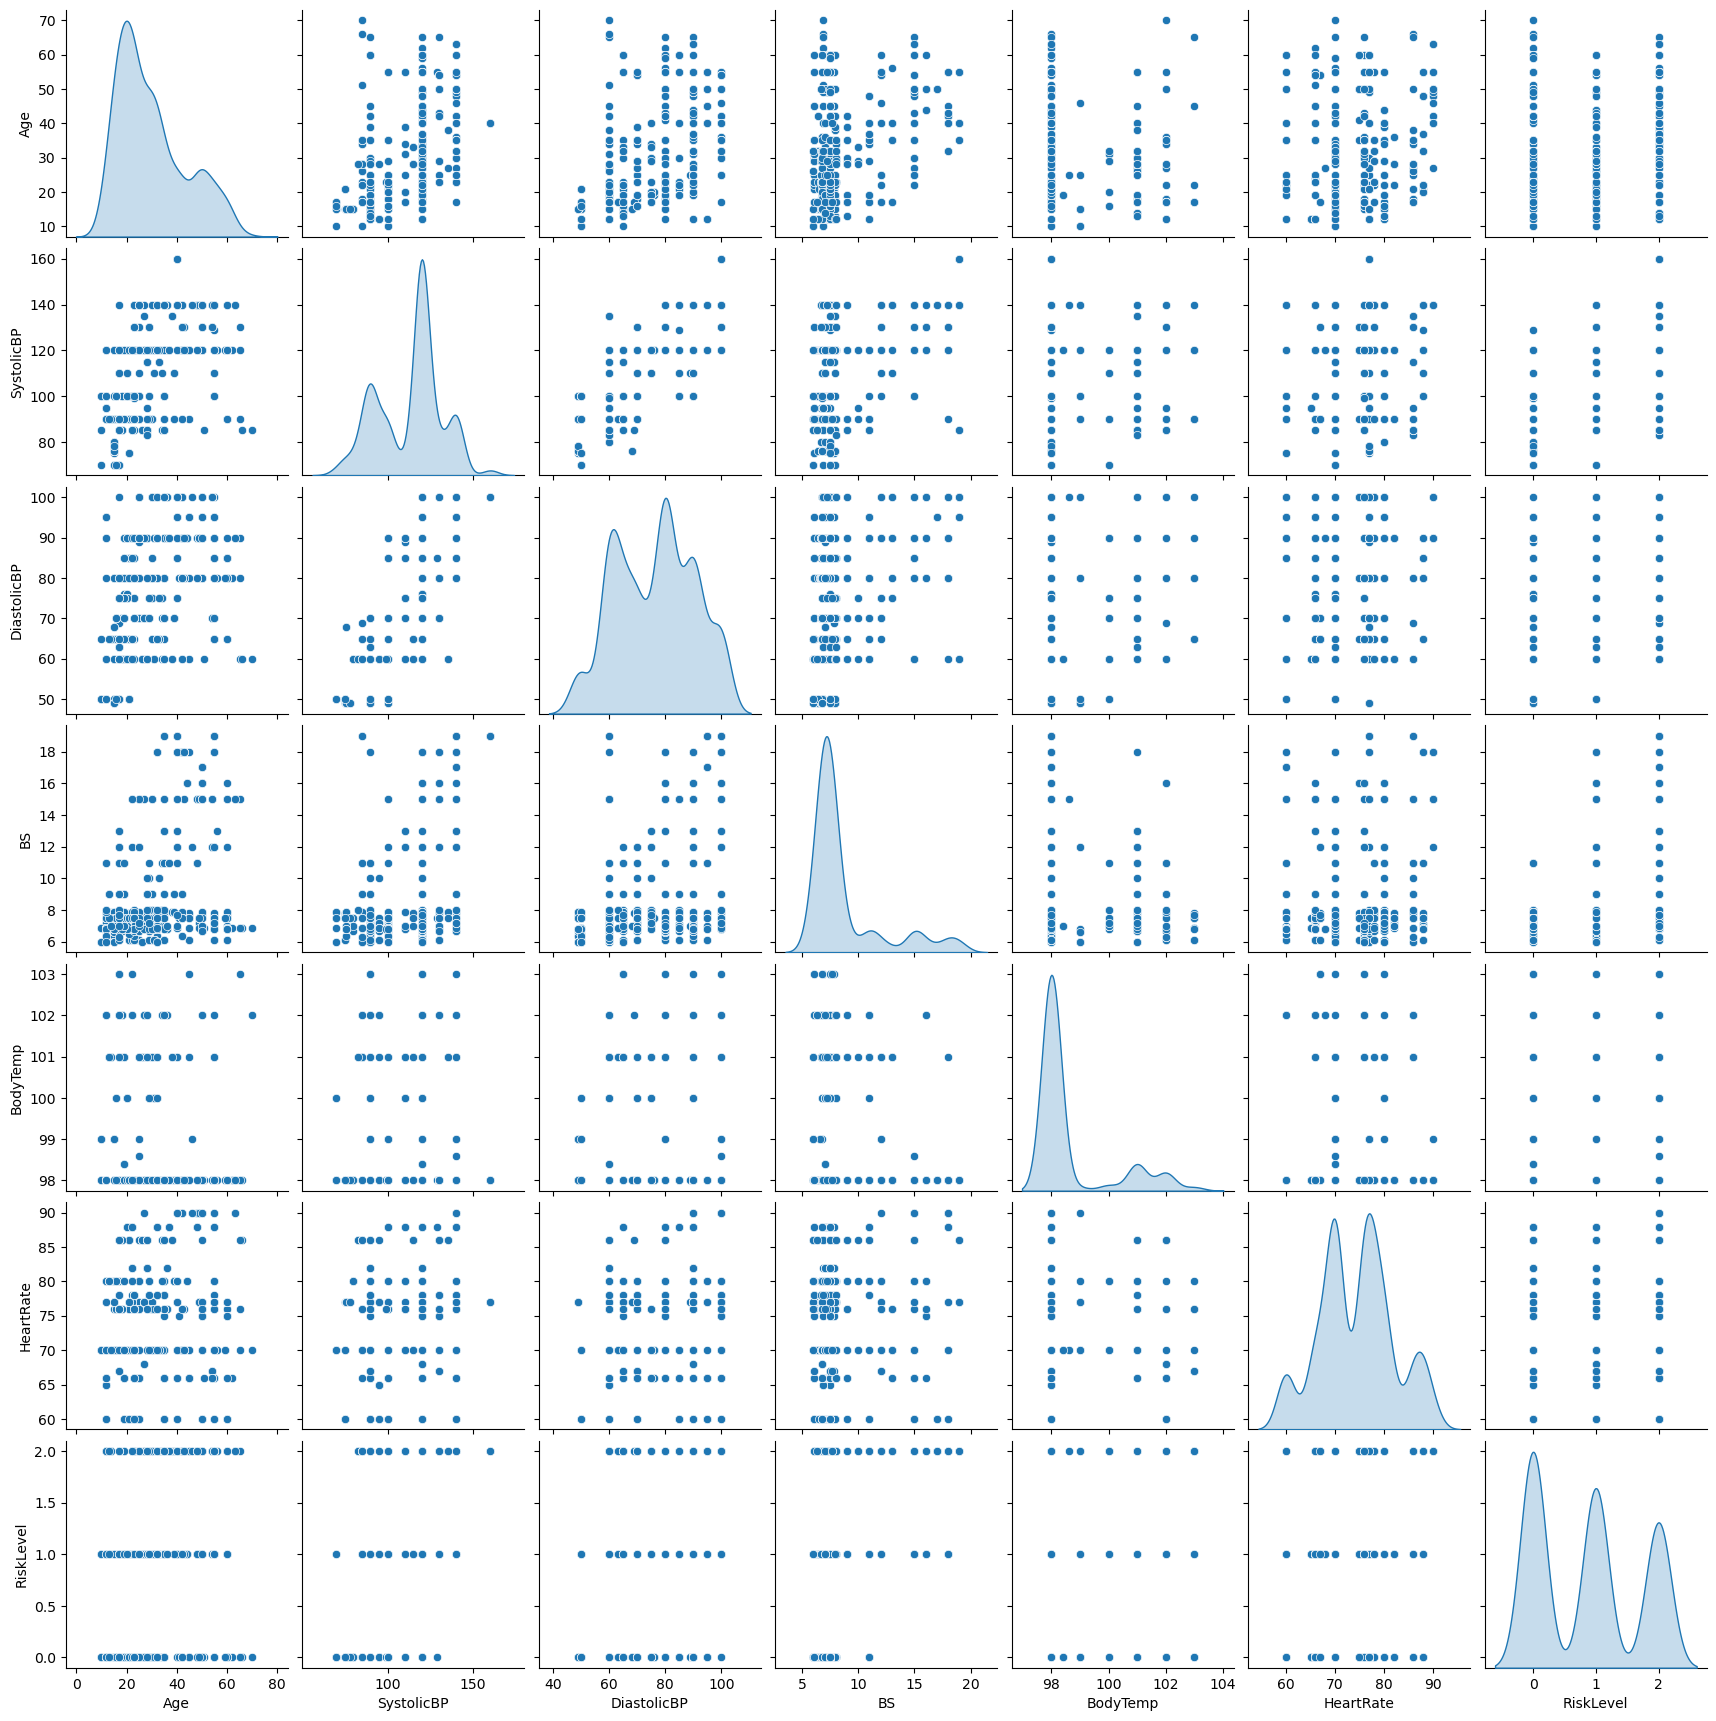

In [639]:
sns.pairplot(data, diag_kind = "kde")
plt.show()

##### Correlation Matrix
The correlation matrix below shows several things. There is a high correlation between the SystolicBP and DiastolicBP features. This makes sense since those are the two part of a blood pressure measurement that are always taken together. In order to remove the this highly correlated relationship, we will remove DiastolicBP from the dataset, since research suggests that SystolicBP is the most important blood pressure measurement (https://pubmed.ncbi.nlm.nih.gov/12698068/#:~:text=In%20this%20review%20we%20compare,a%20better%20predictor%20of%20risk). 

In [641]:
data.corr()

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
Age,1.000000,0.417292,0.398234,0.473299,-0.256640,0.067727,0.265618
SystolicBP,0.417292,1.000000,0.787198,0.425439,-0.286366,-0.018328,0.397768
DiastolicBP,0.398234,0.787198,1.000000,0.423803,-0.257702,-0.051542,0.346826
BS,0.473299,0.425439,0.423803,1.000000,-0.103765,0.149351,0.570097
BodyTemp,-0.256640,-0.286366,-0.257702,-0.103765,1.000000,0.097749,0.163177
HeartRate,0.067727,-0.018328,-0.051542,0.149351,0.097749,1.000000,0.190334
RiskLevel,0.265618,0.397768,0.346826,0.570097,0.163177,0.190334,1.000000


In [643]:
data = data.drop(['DiastolicBP'], axis=1)

### EDA Summary

* The histogram revealed make different data structures across the features, so no common distribution can be assumed for the dataset.There is a small discrepancy with the HeartRate feature that is noted.
* The pairwise plot showed evenly distributed data points across most of the feature pairs, except for the SystolicBP and DiastolicBP pair which showed a slightly linear relationship.
* The correlation matrix showed a high correlation between the SystolicBP and DiastolicBP features. The DiastolicBP feature was removed from the dataset in order to eliminate that colinear relationship. Information about the dataset after the updates is below.

In [645]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1012 entries, 0 to 1013
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Age         1012 non-null   int64  
 1   SystolicBP  1012 non-null   int64  
 2   BS          1012 non-null   float64
 3   BodyTemp    1012 non-null   float64
 4   HeartRate   1012 non-null   int64  
 5   RiskLevel   1012 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 55.3 KB


## MODELS

##### Models Choosen
The unsupervised learning methods tested against this dataset are K Means, Bisecting K Means, Agglomerative Clustering, and DBSCAN. K Means and Bisecting K Means are both centroid based clustering methods that use distance metrics to calculate the clusters. Agglomertaive Clustering is connectivity based clustering method that creates hierarchical clusters. DBSCAN is a density based clustering method that determines clusters based on the density of the data points. These models were chosen to test the data against models of increasing levels of complexity.

##### Data Normalization
These methods need to use normalized data since some of the methods use distances in order to calculate the labels. The code uses the MinMaxScaler in order to normalize the data.

In [818]:
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_data_minmax = MinMaxScaler().fit_transform(X)
X_scaled = pd.DataFrame(X_data_minmax,columns=['Age', 'SystolicBP', 'BS', 'BodyTemp', 'HeartRate'])

#### K Means

The K Means method clusters data by separating samples into specified groups of equal variance, trying to minimize the within cluster sum of squares.

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this method were init and algorithm. The init parameter was cross validated with the two options of k-means++ and random. The algorithm parameter was cross validated with the two options, lloyd and elkan. The n_clusters parameter was set to 3 since we know that is how many labels there are. We will use the Adjusted Rand Index to determine the most accurate model. The best parameters chosen for the method are listed below the code block.

In [910]:
initParams = ['k-means++', 'random']
algParams = ['lloyd', 'elkan']
best_score = 0.0
for ip in initParams:
    for ap in algParams:
        model_kmeans = KMeans(random_state = 1, n_clusters = 3, init = ip, algorithm = ap).fit(X_scaled)
        current_score = adjusted_rand_score(y, model_kmeans.labels_)
        if best_score < current_score:
            ip_best = ip
            ap_best = ap
            best_score = current_score
            kmeans_pred = model_kmeans.predict(X_scaled)
            best_kmodel = model_kmeans
print("Best Init Param:", ip_best, "\nBest Algorithm Param:", ap_best, "\nAdjusted Rand Index:", best_score)

Best Init Param: k-means++ 
Best Algorithm Param: lloyd 
Adjusted Rand Index: 0.2159128928845158


##### Clustering Plot
The plot below shows the K Means clusters when plotted against the normalized BS and BodyTemp features of the dataset. The plot shows that there are three relatively distinct clusters, though they are not very dense. One of the blue cluster data points is located in the yellow cluster section, which indicates mislabeling.

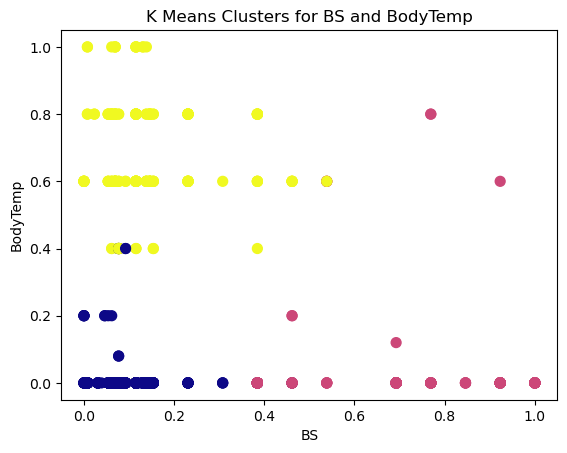

In [890]:
plt.scatter(X_scaled['BS'], X_scaled['BodyTemp'], c=kmeans_pred, s=50, cmap = 'plasma')
plt.xlabel('BS')
plt.ylabel('BodyTemp')
plt.title('K Means Clusters for BS and BodyTemp')
plt.show()

#### Bisecting K Means

The Bisecting K Means method is a variant of the K Means method that uses hierarchical clustering to progressively pick the centroids based on the previous clusterting, rather than creating all the centroids at once.

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this method were init, algorithm, and bisecting strategy. The init parameter was cross validated with the two options of k-means++ and random. The algorithm parameter was cross validated with the two options, lloyd and elkan. The bisecting_strategy parmeter was cross validated with the two options of biggest_inertia and largest_cluster. The biggest_inertia option will bisect the cluster with the largest sum of squares error while the largest_cluster option will split the cluster with largest amount of points assigned to it from the previously calculated clusters. The n_clusters parameter was set to 3. We will use the Adjusted Rand Index to determine the most accurate model. The best parameters chosen for the method are listed below the code block.

In [908]:
initParams = ['k-means++', 'random']
algParams = ['lloyd', 'elkan']
bisectParams = ['biggest_inertia', 'largest_cluster']
best_score = 0.0
for ip in initParams:
    for ap in algParams:
        for bp in bisectParams:
            model_bkmeans = BisectingKMeans(random_state = 1, n_clusters = 3, init = ip, algorithm = ap, bisecting_strategy = bp).fit(X_scaled)
            current_score = adjusted_rand_score(y, model_bkmeans.labels_)
            if best_score < current_score:
                ip_best = ip
                ap_best = ap
                bp_best = bp
                best_score = current_score
                bkmeans_pred = model_bkmeans.predict(X_scaled)
                best_bkmodel = model_bkmeans
print("Best Init Param:", ip_best, "\nBest Algorithm Param:", ap_best, "\nBest Bisecting Strategy Param:", bp_best, "\nAdjusted Rand Index:", best_score)

Best Init Param: k-means++ 
Best Algorithm Param: lloyd 
Best Bisecting Strategy Param: biggest_inertia 
Adjusted Rand Index: 0.2159128928845158


##### Clustering Plot
The plot below shows the Bisecting K Means clusters when plotted against the normalized BS and BodyTemp features of the dataset. This plot is very similar to the K Means plot. Again, there are three relatively distinct clusters and the mislabeled data point is still present.

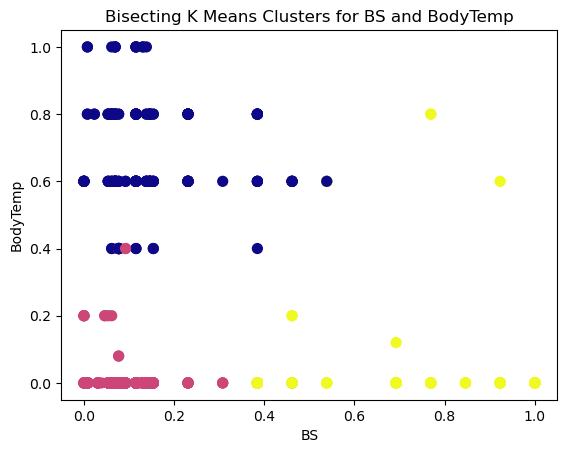

In [811]:
plt.scatter(X_scaled['BS'], X_scaled['BodyTemp'], c=bkmeans_pred, s=50, cmap = 'plasma')
plt.xlabel('BS')
plt.ylabel('BodyTemp')
plt.title('Bisecting K Means Clusters for BS and BodyTemp')
plt.show()

#### Agglomerative Clustering

The Agglomerative Clustering method is a hierarchical clustering method that uses a bottom up approach. Each instance it its own cluster to start and then gets successively merged together.

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this method were metric and linkage. The metric parameter was cross validated using euclidean, l1, l2, manhattan, and cosine. The linkage parameter was cross validated with the options of complete, average, and single. The n_clusters parameter was set to 3. We will use the Adjusted Rand Index to determine the most accurate model. The best parameters chosen for the method are listed below the code block.

In [912]:
metricParams = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']
linkageParams = ['complete', 'average', 'single']
best_score = 0.0
for mp in metricParams:
    for lp in linkageParams:
        model_agg = AgglomerativeClustering(n_clusters = 3, metric = mp, linkage = lp).fit(X_scaled)
        current_score = adjusted_rand_score(y, model_agg.labels_)
        if best_score < current_score:
            mp_best = mp
            lp_best = lp
            best_score = current_score
            agg_pred = model_agg.fit_predict(X_scaled)
            best_aggmodel = model_agg
print("Best Metric Param:", mp_best, "\nBest Linkage Param:", lp_best, "\nAdjusted Rand Index:", best_score)

Best Metric Param: l1 
Best Linkage Param: complete 
Adjusted Rand Index: 0.22077673599082215


##### Clustering Plot
The plot below shows the clusters for Agglomorative Clustering when plotted against the normalized BS and BodyTemp features of the dataset. This plot has more separated clusters, though they are still sparse. Each data point is solidly within its own cluster.

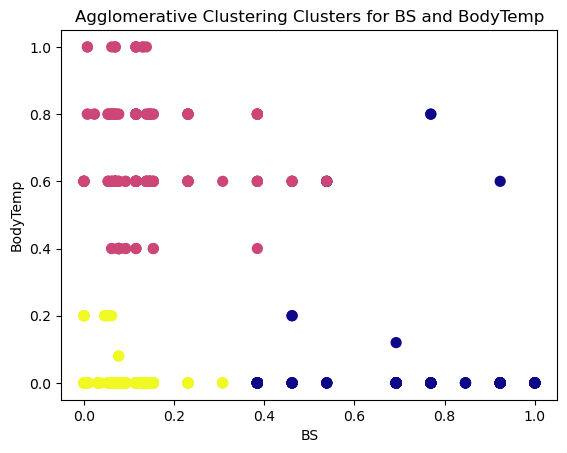

In [809]:
plt.scatter(X_scaled['BS'], X_scaled['BodyTemp'], c=agg_pred, s=50, cmap = 'plasma')
plt.xlabel('BS')
plt.ylabel('BodyTemp')
plt.title('Agglomerative Clustering Clusters for BS and BodyTemp')
plt.show()

#### DBSCAN

The DBSCAN clustering method uses a density based approach. This approach categorizes clusters as core samples, which are samples that are in areas of high density. The eps and min_samples parameters determine te density needed to form a cluster.

##### Hyperparameter Tuning and Cross Validation
The hyperparameters tuned for this method were eps, min_samples, and algorithm. The eps parameters was cross validated with a range from 0.1 to 0.5 with increments of 0.1. The min_samples parameter was cross validated using a range of options from 1 to 10, with steps of 1. The algorithm parameter was cross-validated with the options of auto, ball_tree, kd_tree, and brute. The number of clusters is determined from the parameters and is not passed in. We will use the Adjusted Rand Index to determine the most accurate model. The best parameters chosen for the method are listed below the code block.

In [914]:
epsParams = [0.1, 0.2, 0.3, 0.4, 0.5]
minSampleParams = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
algParams = ['auto', 'ball_tree', 'kd_tree', 'brute']
best_score = 0.0
for ep in epsParams:
    for mp in minSampleParams:
        for ap in algParams:
            model_dbscan = DBSCAN(eps = ep, min_samples = mp, algorithm = ap).fit(X_scaled)
            current_score = adjusted_rand_score(y, model_dbscan.labels_)
            if best_score < current_score:
                ep_best = ep
                mp_best = mp
                ap_best = ap
                best_score = current_score
                dbscan_pred = model_dbscan.fit_predict(X_scaled)
                best_dbmodel = model_dbscan
print("Best Eps Param:", ep_best, "\nBest Min Samples Param:", mp_best, "\nBest Algorithm Param:", ap_best, "\nAdjusted Rand Index:", best_score)
print("Number of labels created:", best_dbmodel.n_features_in_)

Best Eps Param: 0.2 
Best Min Samples Param: 6 
Best Algorithm Param: brute 
Adjusted Rand Index: 0.14436091740307336
Number of labels created: 5


##### Clustering Plot
The plot below shows the DBSCAN clusters when plotted against the normalized BS and BodyTemp features of the dataset. This plot is very different from the other plots since this method chose its own number of clusters to create. It created 5 labels instead of the 3 known labels. The clusters are not very well defined and are all interspersed around each other.

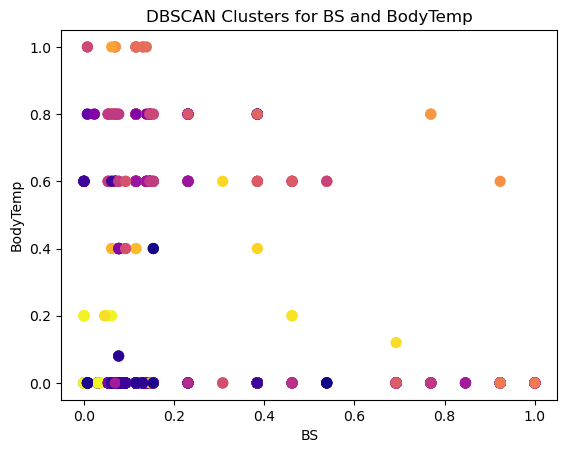

In [816]:
plt.scatter(X_scaled['BS'], X_scaled['BodyTemp'], c=dbscan_pred, s=50, cmap = 'plasma')
plt.xlabel('BS')
plt.ylabel('BodyTemp')
plt.title('DBSCAN Clusters for BS and BodyTemp')
plt.show()

### Models Summary

* 4 different models were trained, K Means, Bisecting K Means, Agglomerative Clustering, and DBSCAN.
* Data was normalized for the use across all the methods.
* Hyperparameter tuning and cross validation was conducted for several parameters in each model. The best performing parameters were saved for each model.
* Clustering plots were created for BS and BodyTemp features for each method.

## RESULTS AND ANALYSIS

### Analysis

##### Scores

Four scores were selected for evaluation that are all used regularly for evaluating unsupervised learning methods.
- Silhouette Score: Assesses how well-defined the clusters are. Range is from -1 to 1, where 1 is a perfectly defined cluster.
- Davies-Bouldin Index: Assesses the effectiveness of the clustering algorithm by evaluating the clusters' compactness and separation. A lower index score indicates that the clusters are better defined.
- Calinski-Harabasz Index: Assesses the quality of the clusters. A higher index score indicates that the clusters are compact and well defined.
- Adjusted Rand Index: Assesses accuracy by comparing the cluster labels to the ground truth. The range is from -1 to 1, where the 1 is a perfectly defined cluster.

The chart below displays the performance of all four models using the four scores listed above. All the models except for the DBSCAN model performed similarly for the Silhouette Score with scores around 0.4, while the DBSCAN performed significantly better with a score closer to 0.6. For the Davies-Bouldin Index, the first three models performing similarly again with scores around 1.042. The DBSCAN method again performed much better with a score around 0.31. With the Calinski-Harabasz Index, the first three models all had a score close to 524 while the DBSCAN method performed much worse with a score at 318. For the Adjusted Rand Index, the two K Means methods had a score of 0.216, the Agglomerative Clusting method had a score of 0.221 and the DBSCAN method had a score of 0.036, which is much worse than the other three methods.

In [833]:
sil_scores = [silhouette_score(X_scaled, best_kmodel.labels_),
              silhouette_score(X_scaled, best_bkmodel.labels_),
              silhouette_score(X_scaled, best_aggmodel.labels_),
              silhouette_score(X_scaled, best_dbmodel.labels_)]

db_scores = [davies_bouldin_score(X_scaled, best_kmodel.labels_),
             davies_bouldin_score(X_scaled, best_bkmodel.labels_),
             davies_bouldin_score(X_scaled, best_aggmodel.labels_),
             davies_bouldin_score(X_scaled, best_dbmodel.labels_)]

ch_scores = [calinski_harabasz_score(X_scaled, best_kmodel.labels_),
             calinski_harabasz_score(X_scaled, best_bkmodel.labels_),
             calinski_harabasz_score(X_scaled, best_aggmodel.labels_),
             calinski_harabasz_score(X_scaled, best_dbmodel.labels_)]

ar_scores = [adjusted_rand_score(y, best_kmodel.labels_),
             adjusted_rand_score(y, best_bkmodel.labels_),
             adjusted_rand_score(y, best_aggmodel.labels_),
             adjusted_rand_score(y, best_dbmodel.labels_)]

def round_scores(scores_list):
    for s in range(len(scores_list)):
        scores_list[s] = round(scores_list[s], 3)

round_scores(sil_scores)
round_scores(db_scores)
round_scores(ch_scores)
round_scores(ar_scores)

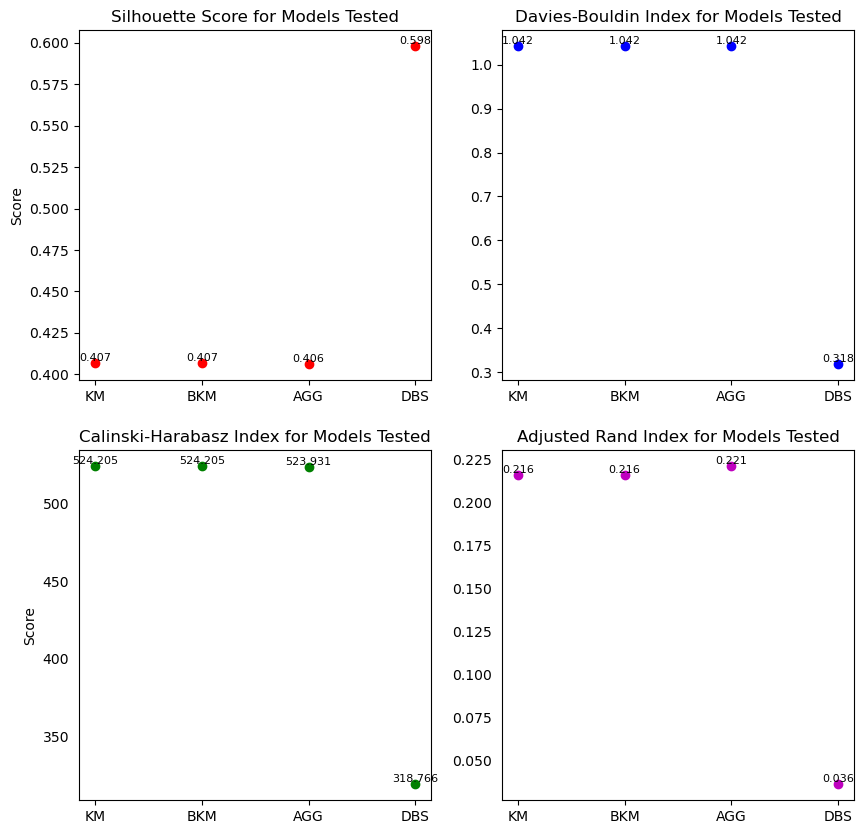

In [839]:
class_type = ['KM', 'BKM', 'AGG', 'DBS']

fig_sc, ax_sc = plt.subplots(2,2, figsize=(10,10))

ax_sc[0,0].plot(class_type, sil_scores, 'or')
for i in range(len(class_type)):
        ax_sc[0,0].text(i,sil_scores[i],sil_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,0].set_xlabel('')
ax_sc[0,0].set_ylabel("Score")
ax_sc[0,0].set_title("Silhouette Score for Models Tested")

ax_sc[0,1].plot(class_type, db_scores, 'ob')
for i in range(len(class_type)):
        ax_sc[0,1].text(i,db_scores[i],db_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[0,1].set_xlabel('')
ax_sc[0,1].set_ylabel('')
ax_sc[0,1].set_title("Davies-Bouldin Index for Models Tested")

ax_sc[1,0].plot(class_type, ch_scores, 'og')
for i in range(len(class_type)):
        ax_sc[1,0].text(i,ch_scores[i],ch_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,0].set_ylabel('')
ax_sc[1,0].tick_params(axis='y', which='both',left=False)
ax_sc[1,0].set_ylabel("Score")
ax_sc[1,0].set_title("Calinski-Harabasz Index for Models Tested")

ax_sc[1,1].plot(class_type, ar_scores, 'om')
for i in range(len(class_type)):
        ax_sc[1,1].text(i,ar_scores[i],ar_scores[i], ha ='center', va = 'bottom', fontsize=8)
ax_sc[1,1].set_ylabel('')
ax_sc[1,1].tick_params(axis='y', which='both',left=False)
ax_sc[1,1].set_title("Adjusted Rand Index for Models Tested")

plt.show()

### Results Summary
* The K Means, Bisecting K Means, and Agglomertative Clusterting methods performed very similary across all four metrics.
* The DBSCAN method had very inconclusive performance results. It performed much better than the other models for two metrics and performed much worse for the other two metrics. This is likely due to it selecting its own number of clusters instead using a pre-set number of clusters like the other three models.
* Overall, the Agglomerative Clustering method was the best model by a small margin, since it had a slightly better score for the Adjusted Rand Index, with the the two K Means methods being close behind.

## Discussion and Conclusion

##### Takeaways
* Agglomerative Clustering provided the best model for this dataset.
* Learned a lot about how to group plots and create subplots for easier visualization.

##### Improvements
* Reconstruct this experiment with more data points. There were only around 1000 instances of the data. If there were more data, it would be easier to make some generalizations about the distribution of the data and possibly make better decisions about outliers.
* Run more instances of the DBSCAN model with other parameters/options to see if the metrics can be improved.
* Try other types of clustering algorithms, like Guassian Mixture.

### Reference
- https://scikit-learn.org/stable/api/sklearn.cluster.html#module-sklearn.cluster
- https://scikit-learn.org/stable/modules/clustering.html#overview-of-clustering-methods
- https://www.geeksforgeeks.org/clustering-in-machine-learning/#types-of-clustering-algorithms
- https://www.geeksforgeeks.org/clustering-metrics/